<a href="https://colab.research.google.com/github/NAVRS/Sentiment_Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.svm import  LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer as tf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
from string import punctuation
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/training.1600000.processed.noemoticon.csv',
                 delimiter=',', encoding='ISO-8859-1')
df.columns = ['sentiment','id','date','query','user','text']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1048572 non-null  int64 
 1   id         1048572 non-null  int64 
 2   date       1048572 non-null  object
 3   query      1048572 non-null  object
 4   user       1048572 non-null  object
 5   text       1048572 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


In [ ]:
df.describe()

,sentiment,id
count,1.048572e+06,1.048572e+06
mean,9.482458e-01,1.976168e+09
std,1.701122e+00,2.300567e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.824526e+09
50%,0.000000e+00,1.990870e+09
75%,0.000000e+00,2.198903e+09
max,4.000000e+00,2.329206e+09


In [ ]:
df.isnull().sum()

,0
sentiment,0
id,0
date,0
query,0
user,0
text,0


In [ ]:
df['sentiment'] = df['sentiment'].replace({4:1})

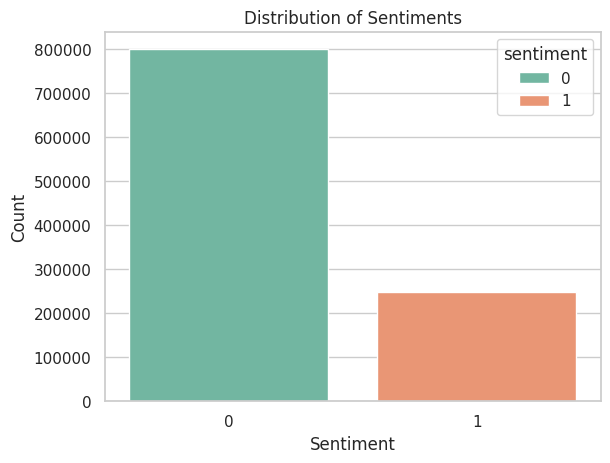

In [ ]:
sns.set(style="whitegrid")

sns.countplot(data=df, x='sentiment', hue='sentiment', palette='Set2')

# Customize plot labels and title if needed
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Show the plot
plt.show()

In [ ]:
df['text'].isnull().sum()

0

In [ ]:
df = df.drop_duplicates('text')

In [ ]:
stuff_to_be_removed = list(punctuation)





def textprocessing(text):
    text = str(text)
    text = text.lower()                                                          # converting all uppercase letters to lowercase
    text = re.sub(r"https\S+|www\S+|https\S+"," ",text,flags=re.MULTILINE)       # removing all links from dataset
    text=re.sub("(\\d|\\W)+"," ",text)
    text = re.sub(r'\@\w+|\#'," ",text)                                          # removing # and @ symbols from dataset
    text = re.sub(r'[^\w\s\`]'," ",text)                                         # removing other symbols like ^ except '
    text_tokens = word_tokenize(text)
    lem = SnowballStemmer("english")
    text = [lem.stem(word) for word in text_tokens if not word in stuff_to_be_removed]
    text1 = " ".join(text)

    return text1

In [ ]:
data_cleaned = pd.DataFrame()
df['text'].head()

,text
0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,my whole body feels itchy and like its on fire
3,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,@Kwesidei not the whole crew


In [ ]:
negative_text = ' '.join(df[df['sentiment'] == 0]['text'])
positive_text = ' '.join(df[df['sentiment'] == 1]['text'])
df = df[['sentiment','text']]
df.head()

,sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


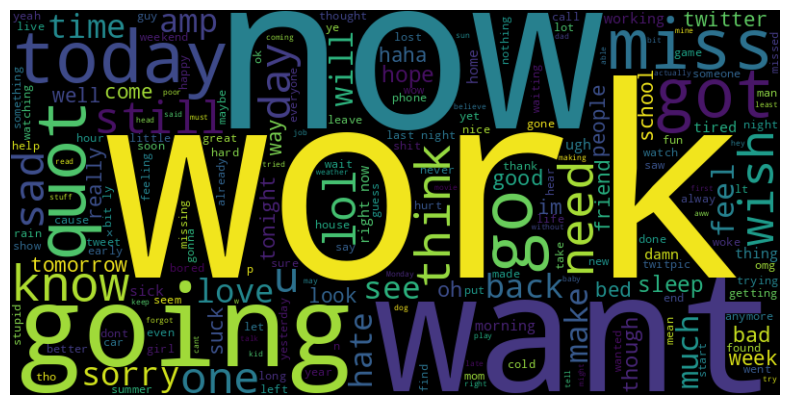

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

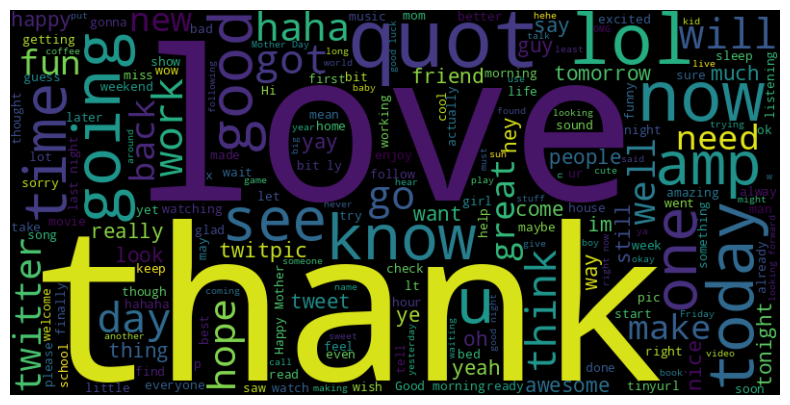

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
x = df['text']
y = df['sentiment']

vectorizer = tf()
vectors = vectorizer.fit_transform(x)

# ngrams reduce accuracy of the model

In [ ]:
X_train_svm, X_temp_svm, y_train_svm, y_temp_svm = train_test_split(vectors, y, test_size=0.3, random_state=52)

X_validation_svm, X_test_svm, y_validation_svm, y_test_svm = train_test_split(X_temp_svm, y_temp_svm, test_size=0.5, random_state=52)

In [ ]:
n_components = 100
svd = TruncatedSVD(n_components=n_components)
X_train_svm_pca = svd.fit_transform(X_train_svm)
X_validation_svm_pca = svd.transform(X_validation_svm)
X_test_svm_pca = svd.transform(X_test_svm)

In [ ]:
svm_model = LinearSVC(dual = True)
svm_model.fit(X_train_svm_pca, y_train_svm)


y_pred_validation_svm = svm_model.predict(X_validation_svm_pca)
accuracy_validation_svm = accuracy_score(y_validation_svm, y_pred_validation_svm)
print(f"Accuracy on the validation set: {accuracy_validation_svm}")


y_pred_test_svm = svm_model.predict(X_test_svm_pca)
accuracy_test_svm = accuracy_score(y_test_svm, y_pred_test_svm)
print(f"Accuracy on the test set: {accuracy_test_svm}")

Accuracy on the validation set: 0.7862115557843263
Accuracy on the test set: 0.786996525543688


In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#               'C': [0.1, 1, 10, 100]}  # You can adjust other hyperparameters as well

# # Create a grid search
# grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')

# # Fit the grid search to the data
# grid_search.fit(train_vectors, train_labels)

# # Get the best parameters
# best_params = grid_search.best_params_
# print(f"Best Parameters: {best_params}")

# # Get the best model
# best_model = grid_search.best_estimator_

In [ ]:
classifier = CalibratedClassifierCV(LinearSVC(dual = True), method='sigmoid')
classifier.fit(X_train_svm, y_train_svm)

CalibratedClassifierCV(estimator=LinearSVC(dual=True))

In [ ]:
svm_predictions_train = classifier.predict(X_train_svm)

accuracy = accuracy_score(y_train_svm, svm_predictions_train)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_train_svm, svm_predictions_train))

Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95    553132
           1       0.91      0.74      0.82    172160

    accuracy                           0.92    725292
   macro avg       0.92      0.86      0.89    725292
weighted avg       0.92      0.92      0.92    725292



In [ ]:
svm_prediction_test = classifier.predict(X_test_svm)


accuracy = accuracy_score(y_test_svm, svm_prediction_test)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_test_svm, svm_prediction_test))

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91    118493
           1       0.75      0.55      0.63     36927

    accuracy                           0.85    155420
   macro avg       0.81      0.75      0.77    155420
weighted avg       0.84      0.85      0.84    155420



In [ ]:
svm_predictions_validation= classifier.predict(X_validation_svm)

accuracy = accuracy_score(y_validation_svm, svm_predictions_validation)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_validation_svm, svm_predictions_validation))

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91    118556
           1       0.75      0.54      0.63     36864

    accuracy                           0.85    155420
   macro avg       0.81      0.74      0.77    155420
weighted avg       0.84      0.85      0.84    155420



In [ ]:
## majority class 0
df_majority_knn = df[df['sentiment']==0]
## minority class 1
df_minority_knn = df[df['sentiment']==1]

df_majority_downsampled_knn = resample(df_majority_knn,
                                 replace=False,
                                 n_samples=len(df_minority_knn)//5,
                                 random_state=134)

df_minority_downsampled_knn = resample(df_minority_knn,
                                 replace=False,
                                 n_samples=len(df_minority_knn)//5,
                                 random_state=134)

In [ ]:
df = pd.concat([df_majority_downsampled_knn, df_minority_downsampled_knn])

x = df['text']
y = df['sentiment']


vectorizer2 = tf()
vectors = vectorizer2.fit_transform(x)

vectors.shape

(98380, 96042)

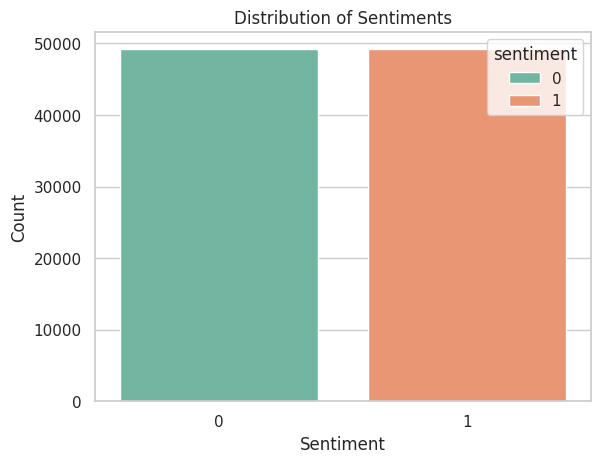

In [ ]:
sns.set(style="whitegrid")

sns.countplot(data=df, x='sentiment', hue='sentiment', palette='Set2')

# Customize plot labels and title if needed
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Show the plot
plt.show()

In [ ]:
X_train_knn, X_temp_knn, y_train_knn, y_temp_knn = train_test_split(vectors, y, test_size=0.3, random_state=52)

X_validation_knn, X_test_knn, y_validation_knn, y_test_knn = train_test_split(X_temp_knn, y_temp_knn, test_size=0.5, random_state=52)

In [ ]:
n_components = 100
svd = TruncatedSVD(n_components=n_components)
X_train_knn_pca = svd.fit_transform(X_train_knn)
X_validation_knn_pca = svd.transform(X_validation_knn)
X_test_knn_pca = svd.transform(X_test_knn)


knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_knn_pca, y_train_knn)


y_pred_validation_knn = knn_model.predict(X_validation_knn_pca)
accuracy_validation_knn = accuracy_score(y_validation_knn, y_pred_validation_knn)
print(f"Accuracy on the validation set: {accuracy_validation_knn}")

y_pred_test_knn = knn_model.predict(X_test_knn_pca)
accuracy_test_knn = accuracy_score(y_test_knn, y_pred_test_knn)
print(f"Accuracy on the test set: {accuracy_test_knn}")

Accuracy on the validation set: 0.6405095886697838
Accuracy on the test set: 0.6407128820220912


In [ ]:
l = int(np.sqrt(len(x)))
print(l)

313


In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=l)  # You can experiment with different values of k
knn_classifier.fit(X_train_knn, y_train_knn)


knn_predictions_train =knn_classifier.predict(X_train_knn)
knn_accuracy = accuracy_score(y_train_knn, knn_predictions_train)
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:")
print(classification_report(y_train_knn, knn_predictions_train))

KNN Accuracy: 0.74
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77     34502
           1       0.81      0.63      0.71     34364

    accuracy                           0.74     68866
   macro avg       0.75      0.74      0.74     68866
weighted avg       0.75      0.74      0.74     68866



In [ ]:
knn_prediction_test = knn_classifier.predict(X_test_knn)
knn_accuracy = accuracy_score(y_test_knn, knn_prediction_test)
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:")
print(classification_report(y_test_knn, knn_prediction_test))

KNN Accuracy: 0.74
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.76      7324
           1       0.81      0.63      0.71      7433

    accuracy                           0.74     14757
   macro avg       0.75      0.74      0.74     14757
weighted avg       0.75      0.74      0.74     14757



In [ ]:
knn_predictions_validation =knn_classifier.predict(X_validation_knn)
knn_accuracy = accuracy_score(y_validation_knn, knn_predictions_validation)
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:")

print(classification_report(y_validation_knn, knn_predictions_validation))

KNN Accuracy: 0.73
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.85      0.76      7364
           1       0.81      0.61      0.70      7393

    accuracy                           0.73     14757
   macro avg       0.75      0.73      0.73     14757
weighted avg       0.75      0.73      0.73     14757



In [ ]:
def metrics(y_train, y_train_pred, y_test, y_test_pred):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm_train = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=None)
    disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
    axes[0].set_title('Training Confusion Matrix ')


    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=None)
    disp_test.plot(ax=axes[1], cmap='Blues', values_format='d')
    axes[1].set_title('Testing Confusion Matrix')

    plt.show()

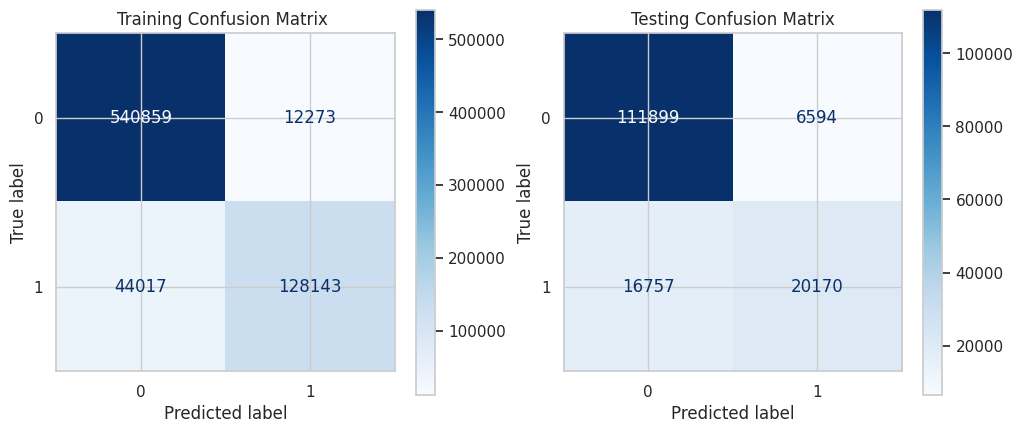

In [ ]:
metrics(y_train_svm,svm_predictions_train ,y_test_svm,svm_prediction_test)

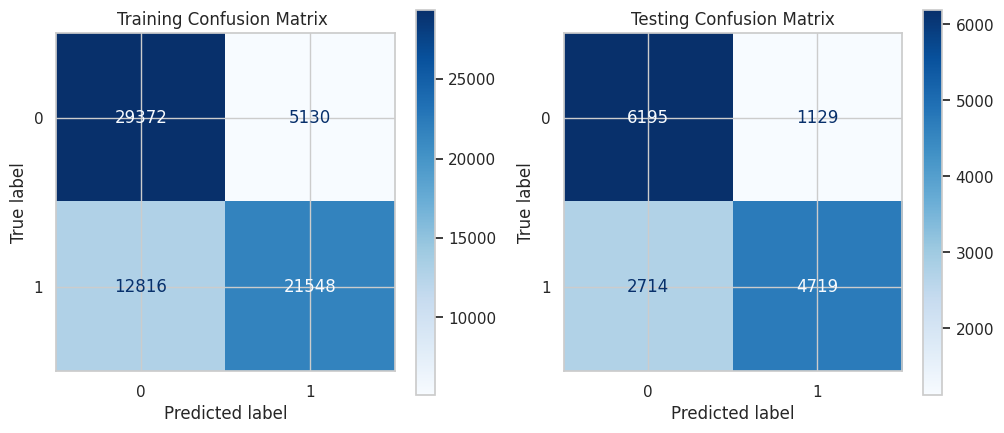

In [ ]:
metrics(y_train_knn,knn_predictions_train ,y_test_knn,knn_prediction_test)

In [ ]:
new_text = "i happy to hear that"
new_text_vector = vectorizer.transform([new_text])

prediction = classifier.predict(new_text_vector)

if prediction[0] == 1:
    print("positve user comment")
else:
    print("negative user comment")

positve user comment
